In [49]:
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
from datetime import datetime, timedelta
import pickle
import os
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings('ignore')

In [5]:
START_DATE = '2018-01-01'
END_DATE = '2025-01-01'
stocks = ['SPY', '^VIX']

In [6]:
spy = yf.download(stocks[0], start = START_DATE, end = END_DATE)
vix = yf.download(stocks[1], start = START_DATE, end = END_DATE)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
print(f"\nSPY data shape: {spy.shape}")
print(f"VIX data shape: {vix.shape}")
print(f"\nSPY columns: {list(spy.columns)}")
print(f"VIX columns: {list(vix.columns)}")


SPY data shape: (1761, 5)
VIX data shape: (1761, 5)

SPY columns: [('Close', 'SPY'), ('High', 'SPY'), ('Low', 'SPY'), ('Open', 'SPY'), ('Volume', 'SPY')]
VIX columns: [('Close', '^VIX'), ('High', '^VIX'), ('Low', '^VIX'), ('Open', '^VIX'), ('Volume', '^VIX')]


In [8]:
print(spy.head(3))
print(vix.head(3))

Price            Close        High         Low        Open    Volume
Ticker             SPY         SPY         SPY         SPY       SPY
Date                                                                
2018-01-02  238.568802  238.604315  237.352751  237.743311  86655700
2018-01-03  240.077744  240.228653  238.737411  238.737411  90070400
2018-01-04  241.089645  241.577859  240.139900  240.725740  80636400
Price      Close   High   Low   Open Volume
Ticker      ^VIX   ^VIX  ^VIX   ^VIX   ^VIX
Date                                       
2018-01-02  9.77  11.07  9.52  10.95      0
2018-01-03  9.15   9.65  8.94   9.56      0
2018-01-04  9.22   9.31  8.92   9.01      0


In [12]:
spy_missing = spy.isnull().sum()
vix_missing = vix.isnull().sum()

print(f"\nSPY missing values:\n{spy_missing}")
print(f"\nVIX missing values:\n{vix_missing}")


SPY missing values:
Price   Ticker
Close   SPY       0
High    SPY       0
Low     SPY       0
Open    SPY       0
Volume  SPY       0
dtype: int64

VIX missing values:
Price   Ticker
Close   ^VIX      0
High    ^VIX      0
Low     ^VIX      0
Open    ^VIX      0
Volume  ^VIX      0
dtype: int64


In [15]:
common_dates = spy.index.intersection(vix.index)
print(f"\nCommon trading days: {len(common_dates)}")
print(f"SPY unique days: {len(spy.index)}")
print(f"VIX unique days: {len(vix.index)}")


Common trading days: 1761
SPY unique days: 1761
VIX unique days: 1761


In [18]:
price_df = pd.DataFrame(index = spy.index)
price_df['spy_open'] = spy['Open']
price_df['spy_high'] = spy['High']
price_df['spy_low'] = spy['Low']
price_df['spy_close'] = spy['Close']

# Add VIX close price
price_df['vix_close'] = vix['Close']

In [19]:
price_df.head(5)

,spy_open,spy_high,spy_low,spy_close,vix_close
Date,,,,,
2018-01-02,237.743311,238.604315,237.352751,238.568802,9.77
2018-01-03,238.737411,240.228653,238.737411,240.077744,9.15
2018-01-04,240.725740,241.577859,240.139900,241.089645,9.22
2018-01-05,241.888465,242.820467,241.391393,242.696213,9.22
2018-01-08,242.598606,243.299843,242.305700,243.140076,9.52


In [57]:
price_df.to_pickle("PriceData_SPYandVIX")

In [20]:
volume_df = pd.DataFrame(index=vix.index)
volume_df['spy_volume'] = spy['Volume']
volume_df['vix_volume'] = vix['Volume']

In [21]:
volume_df.head(5)

,spy_volume,vix_volume
Date,,
2018-01-02,86655700,0
2018-01-03,90070400,0
2018-01-04,80636400,0
2018-01-05,83524000,0
2018-01-08,57319200,0


In [24]:
features_df = price_df.copy()

# Calculate basic returns
features_df['spy_return_1d'] = features_df['spy_close'].pct_change()
features_df['spy_return_5d'] = features_df['spy_close'].pct_change(5)
features_df['spy_return_10d'] = features_df['spy_close'].pct_change(10)

# Calculate VIX changes
features_df['vix_change_1d'] = features_df['vix_close'].pct_change()

# Gap and overnight returns
features_df['spy_gap'] = (features_df['spy_open'] - features_df['spy_close'].shift(1)) / features_df['spy_close'].shift(1)
features_df['spy_overnight_return'] = features_df['spy_gap']

# High-low range
features_df['spy_hl_range'] = (features_df['spy_high'] - features_df['spy_low']) / features_df['spy_close']

print(f"✅ Basic features created")
print(f"New columns added: spy_return_1d, spy_return_5d, spy_return_10d, vix_change_1d, spy_gap, spy_overnight_return, spy_hl_range")

✅ Basic features created
New columns added: spy_return_1d, spy_return_5d, spy_return_10d, vix_change_1d, spy_gap, spy_overnight_return, spy_hl_range


In [25]:
print("\n📊 Basic Features Preview:")
print(features_df[['spy_close', 'spy_return_1d', 'spy_return_5d', 'vix_close', 'vix_change_1d']].head(10))


📊 Basic Features Preview:
             spy_close  spy_return_1d  spy_return_5d  vix_close  vix_change_1d
Date                                                                          
2018-01-02  238.568802            NaN            NaN       9.77            NaN
2018-01-03  240.077744       0.006325            NaN       9.15      -0.063460
2018-01-04  241.089645       0.004215            NaN       9.22       0.007650
2018-01-05  242.696213       0.006664            NaN       9.22       0.000000
2018-01-08  243.140076       0.001829            NaN       9.52       0.032538
2018-01-09  243.690353       0.002263       0.021468      10.08       0.058823
2018-01-10  243.317581      -0.001530       0.013495       9.82      -0.025794
2018-01-11  245.092850       0.007296       0.016605       9.88       0.006110
2018-01-12  246.690567       0.006519       0.016458      10.16       0.028340
2018-01-16  245.847244      -0.003419       0.011134      11.66       0.147638


In [27]:
ma_windows = [5, 10, 20, 50]
for window in ma_windows:
    features_df[f'spy_sma_{window}'] = features_df['spy_close'].rolling(window=window).mean()
    features_df[f'vix_sma_{window}'] = features_df['vix_close'].rolling(window=window).mean()

# Exponential Moving Averages
ema_windows = [12, 26]
for window in ema_windows:
    features_df[f'spy_ema_{window}'] = features_df['spy_close'].ewm(span=window).mean()

# Price relative to moving averages
features_df['spy_price_to_sma20'] = features_df['spy_close'] / features_df['spy_sma_20']
features_df['spy_price_to_sma50'] = features_df['spy_close'] / features_df['spy_sma_50']
features_df['vix_price_to_sma10'] = features_df['vix_close'] / features_df['vix_sma_10']

# Moving average crossovers (binary signals)
features_df['spy_sma5_above_sma20'] = (features_df['spy_sma_5'] > features_df['spy_sma_20']).astype(int)
features_df['spy_sma20_above_sma50'] = (features_df['spy_sma_20'] > features_df['spy_sma_50']).astype(int)

In [29]:
print(f"✅ Moving average features created")
ma_cols = [col for col in features_df.columns if 'sma' in col or 'ema' in col or 'price_to' in col or 'above' in col]
print(f"Moving average columns: {ma_cols}")

# Preview moving average features
print("\n📊 Moving Average Features Preview:")
print(features_df[['spy_close', 'spy_sma_10', 'spy_sma_20', 'spy_price_to_sma20']].tail(10))

✅ Moving average features created
Moving average columns: ['spy_sma_5', 'vix_sma_5', 'spy_sma_10', 'vix_sma_10', 'spy_sma_20', 'vix_sma_20', 'spy_sma_50', 'vix_sma_50', 'spy_ema_12', 'spy_ema_26', 'spy_price_to_sma20', 'spy_price_to_sma50', 'vix_price_to_sma10', 'spy_sma5_above_sma20', 'spy_sma20_above_sma50']

📊 Moving Average Features Preview:
             spy_close  spy_sma_10  spy_sma_20  spy_price_to_sma20
Date                                                              
2024-12-17  598.686829  600.052997  596.109409            1.004324
2024-12-18  580.843872  597.934833  595.910278            0.974717
2024-12-19  580.665405  595.897894  595.692313            0.974774
2024-12-20  587.639832  594.444464  595.666040            0.986526
2024-12-23  591.158813  593.653027  595.724573            0.992336
2024-12-24  597.729553  593.704926  596.011575            1.002882
2024-12-26  597.769348  593.299121  596.146014            1.002723
2024-12-27  591.476868  592.574164  596.055988   

In [30]:
vol_windows = [5, 10, 20]
for window in vol_windows:
    features_df[f'spy_volatility_{window}d'] = features_df['spy_return_1d'].rolling(window=window).std()

# Bollinger Bands
features_df['spy_bb_upper'] = features_df['spy_sma_20'] + (features_df['spy_volatility_20d'] * 2)
features_df['spy_bb_lower'] = features_df['spy_sma_20'] - (features_df['spy_volatility_20d'] * 2)
features_df['spy_bb_position'] = (features_df['spy_close'] - features_df['spy_bb_lower']) / (features_df['spy_bb_upper'] - features_df['spy_bb_lower'])

# VIX relative position
features_df['vix_relative_to_ma'] = features_df['vix_close'] / features_df['vix_sma_10']

# High-Low volatility
features_df['spy_hl_volatility'] = features_df['spy_hl_range']

In [31]:
print(f"✅ Volatility features created")
vol_cols = [col for col in features_df.columns if 'volatility' in col or 'bb_' in col or 'vix_relative' in col]
print(f"Volatility columns: {vol_cols}")

# Preview volatility features
print("\n📊 Volatility Features Preview:")
print(features_df[['spy_close', 'spy_volatility_10d', 'spy_bb_position', 'vix_close', 'vix_relative_to_ma']].tail(10))

✅ Volatility features created
Volatility columns: ['spy_volatility_5d', 'spy_volatility_10d', 'spy_volatility_20d', 'spy_bb_upper', 'spy_bb_lower', 'spy_bb_position', 'vix_relative_to_ma', 'spy_hl_volatility']

📊 Volatility Features Preview:
             spy_close  spy_volatility_10d  spy_bb_position  vix_close  \
Date                                                                     
2024-12-17  598.686829            0.004744       160.705604  15.870000   
2024-12-18  580.843872            0.010153      -470.049059  27.620001   
2024-12-19  580.665405            0.010190      -468.900854  24.090000   
2024-12-20  587.639832            0.011223      -238.898672  18.360001   
2024-12-23  591.158813            0.011468      -134.381101  16.780001   
2024-12-24  597.729553            0.012080        49.367399  14.270000   
2024-12-26  597.769348            0.011785        47.045097  14.730000   
2024-12-27  591.476868            0.012133      -126.360614  15.950000   
2024-12-30  584.72

In [32]:
features_df['spy_volume'] = volume_df['spy_volume']

# Volume moving averages
for window in [10, 20]:
    features_df[f'spy_volume_ma_{window}'] = features_df['spy_volume'].rolling(window=window).mean()

# Relative volume
features_df['spy_volume_ratio_10d'] = features_df['spy_volume'] / features_df['spy_volume_ma_10']
features_df['spy_volume_ratio_20d'] = features_df['spy_volume'] / features_df['spy_volume_ma_20']

# Price-volume relationship
features_df['spy_price_volume_trend'] = features_df['spy_return_1d'] * features_df['spy_volume_ratio_10d']

In [34]:
print(f"✅ Volume features created")
vol_cols = [col for col in features_df.columns if 'volume' in col]
print(f"Volume columns: {vol_cols}")

# Preview volume features
print("\n📊 Volume Features Preview:")
print(features_df[['spy_volume', 'spy_volume_ma_10', 'spy_volume_ratio_10d', 'spy_price_volume_trend']].tail(10))

✅ Volume features created
Volume columns: ['spy_volume', 'spy_volume_ma_10', 'spy_volume_ma_20', 'spy_volume_ratio_10d', 'spy_volume_ratio_20d', 'spy_price_volume_trend']

📊 Volume Features Preview:
            spy_volume  spy_volume_ma_10  spy_volume_ratio_10d  \
Date                                                             
2024-12-17    55773500        37036340.0              1.505913   
2024-12-18   108248700        43582450.0              2.483768   
2024-12-19    85919500        49298180.0              1.742853   
2024-12-20   125716700        58745700.0              2.140015   
2024-12-23    57635800        61035010.0              0.944307   
2024-12-24    33160100        60627570.0              0.546948   
2024-12-26    41219100        61881710.0              0.666095   
2024-12-27    64969300        65224260.0              0.996091   
2024-12-30    56578800        67291670.0              0.840799   
2024-12-31    57052700        68627420.0              0.831340   

        

In [35]:
# RSI Calculation
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

features_df['spy_rsi_14'] = calculate_rsi(features_df['spy_close'])

# MACD
features_df['spy_macd'] = features_df['spy_ema_12'] - features_df['spy_ema_26']
features_df['spy_macd_signal'] = features_df['spy_macd'].ewm(span=9).mean()
features_df['spy_macd_histogram'] = features_df['spy_macd'] - features_df['spy_macd_signal']

# Price momentum
features_df['spy_momentum_5d'] = features_df['spy_close'] / features_df['spy_close'].shift(5) - 1
features_df['spy_momentum_10d'] = features_df['spy_close'] / features_df['spy_close'].shift(10) - 1

# Price position in recent range (percentile rank)
for window in [10, 20]:
    features_df[f'spy_price_rank_{window}d'] = features_df['spy_close'].rolling(window).rank(pct=True)

In [37]:
print(f"✅ Momentum and technical indicators created")
momentum_cols = [col for col in features_df.columns if any(x in col for x in ['rsi', 'macd', 'momentum', 'rank'])]
print(f"Momentum columns: {momentum_cols}")

# Preview momentum features
print("\n📊 Momentum Features Preview:")
print(features_df[['spy_close', 'spy_rsi_14', 'spy_macd', 'spy_momentum_5d', 'spy_price_rank_10d']].tail(5))

✅ Momentum and technical indicators created
Momentum columns: ['spy_rsi_14', 'spy_macd', 'spy_macd_signal', 'spy_macd_histogram', 'spy_momentum_5d', 'spy_momentum_10d', 'spy_price_rank_10d', 'spy_price_rank_20d']

📊 Momentum Features Preview:
             spy_close  spy_rsi_14  spy_macd  spy_momentum_5d  \
Date                                                            
2024-12-24  597.729553   46.098033  1.144523        -0.001599   
2024-12-26  597.769348   46.981904  1.431794         0.029139   
2024-12-27  591.476868   40.972902  1.138584         0.018619   
2024-12-30  584.727173   38.596105  0.357448        -0.004957   
2024-12-31  582.599915   38.434393 -0.428323        -0.014478   

            spy_price_rank_10d  
Date                            
2024-12-24                 0.5  
2024-12-26                 0.6  
2024-12-27                 0.5  
2024-12-30                 0.3  
2024-12-31                 0.3  


In [38]:
features_df['next_day_return'] = features_df['spy_return_1d'].shift(-1)

upper_thresh_q = features_df['next_day_return'].quantile(0.6)
lower_thresh_q = features_df['next_day_return'].quantile(0.4)

features_df['target_quantile'] = np.select([
    features_df['next_day_return'] > upper_thresh_q,
    features_df['next_day_return'] < lower_thresh_q
], [2, 0], default=1)  # 2=positive, 1=neutral, 0=negative

features_df['target'] = features_df['target_quantile']

In [39]:
print(f"\n📈 Class Distribution (Quantile Method):")
quantile_dist = features_df['target_quantile'].value_counts().sort_index()
for i, count in quantile_dist.items():
    class_name = ['Negative', 'Neutral', 'Positive'][i]
    pct = count / len(features_df) * 100
    print(f"  {class_name} ({i}): {count} samples ({pct:.1f}%)")
print(f"Thresholds: {lower_thresh_q:.4f} < neutral < {upper_thresh_q:.4f}")


📈 Class Distribution (Quantile Method):
  Negative (0): 704 samples (40.0%)
  Neutral (1): 353 samples (20.0%)
  Positive (2): 704 samples (40.0%)
Thresholds: -0.0009 < neutral < 0.0028


In [40]:
print("🧹 Cleaning dataset and preparing for modeling...")

print(f"Dataset shape before cleaning: {features_df.shape}")
features_clean = features_df.dropna().copy()
print(f"Dataset shape after removing NaN: {features_clean.shape}")

🧹 Cleaning dataset and preparing for modeling...
Dataset shape before cleaning: (1761, 52)
Dataset shape after removing NaN: (1711, 52)


In [41]:
if features_clean['target'].iloc[-1] != features_clean['target'].iloc[-1]:  # Check if last target is NaN
    features_clean = features_clean[:-1]
    print(f"Dataset shape after removing last row: {features_clean.shape}")

In [42]:
exclude_cols = ['target', 'target_quantile', 'target_absolute', 'next_day_return', 
                'spy_open', 'spy_high', 'spy_low', 'spy_close', 'spy_adj_close', 'vix_close']
feature_columns = [col for col in features_clean.columns if col not in exclude_cols]

In [43]:
print(f"📊 Final shape: {features_clean.shape}")
print(f"📅 Date range: {features_clean.index[0].date()} to {features_clean.index[-1].date()}")
print(f"🎯 Total features: {len(feature_columns)}")
print(f"📋 Feature list: {feature_columns}")

📊 Final shape: (1711, 52)
📅 Date range: 2018-03-14 to 2024-12-30
🎯 Total features: 44
📋 Feature list: ['spy_return_1d', 'spy_return_5d', 'spy_return_10d', 'vix_change_1d', 'spy_gap', 'spy_overnight_return', 'spy_hl_range', 'spy_sma_5', 'vix_sma_5', 'spy_sma_10', 'vix_sma_10', 'spy_sma_20', 'vix_sma_20', 'spy_sma_50', 'vix_sma_50', 'spy_ema_12', 'spy_ema_26', 'spy_price_to_sma20', 'spy_price_to_sma50', 'vix_price_to_sma10', 'spy_sma5_above_sma20', 'spy_sma20_above_sma50', 'spy_volatility_5d', 'spy_volatility_10d', 'spy_volatility_20d', 'spy_bb_upper', 'spy_bb_lower', 'spy_bb_position', 'vix_relative_to_ma', 'spy_hl_volatility', 'spy_volume', 'spy_volume_ma_10', 'spy_volume_ma_20', 'spy_volume_ratio_10d', 'spy_volume_ratio_20d', 'spy_price_volume_trend', 'spy_rsi_14', 'spy_macd', 'spy_macd_signal', 'spy_macd_histogram', 'spy_momentum_5d', 'spy_momentum_10d', 'spy_price_rank_10d', 'spy_price_rank_20d']


In [44]:
final_dist = features_clean['target'].value_counts().sort_index()
print(f"\n📈 Final Class Distribution:")
for i, count in final_dist.items():
    class_name = ['Negative', 'Neutral', 'Positive'][i]
    pct = count / len(features_clean) * 100
    print(f"  {class_name} ({i}): {count} samples ({pct:.1f}%)")


📈 Final Class Distribution:
  Negative (0): 686 samples (40.1%)
  Neutral (1): 341 samples (19.9%)
  Positive (2): 684 samples (40.0%)


In [45]:
features_clean

,spy_open,spy_high,spy_low,spy_close,vix_close,spy_return_1d,spy_return_5d,spy_return_10d,vix_change_1d,spy_gap,...,spy_macd,spy_macd_signal,spy_macd_histogram,spy_momentum_5d,spy_momentum_10d,spy_price_rank_10d,spy_price_rank_20d,next_day_return,target_quantile,target
Date,,,,,,,,,,,,,,,,,,,,,
2018-03-14,246.592924,246.779319,243.805775,244.364960,17.230000,-0.005132,0.009238,0.013436,0.053823,0.003939,...,0.761259,0.128807,0.632452,0.009238,0.013436,0.7,0.80,-0.001090,0,0
2018-03-15,244.879829,245.527783,243.592753,244.098709,16.590000,-0.001090,0.003283,0.027269,-0.037144,0.002107,...,0.733821,0.249812,0.484010,0.003283,0.027269,0.6,0.75,0.001084,1,1
2018-03-16,244.630687,245.423856,244.309873,244.363342,15.800000,0.001084,-0.012808,0.023109,-0.047619,0.002179,...,0.724697,0.344789,0.379907,-0.012808,0.023109,0.6,0.75,-0.013530,0,0
2018-03-19,243.605876,244.541611,239.390553,241.057068,19.020000,-0.013530,-0.024941,-0.002265,0.203797,-0.003100,...,0.449666,0.365765,0.083901,-0.024941,-0.002265,0.1,0.30,0.001700,1,1
2018-03-20,241.458044,242.108620,240.780734,241.466965,18.200001,0.001700,-0.016930,-0.003096,-0.043112,0.001663,...,0.261320,0.344876,-0.083555,-0.016930,-0.003096,0.2,0.35,-0.001919,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,587.381389,591.765177,584.170528,591.158813,16.780001,0.005988,-0.016642,-0.013211,-0.086057,-0.000440,...,0.765264,2.968152,-2.202887,-0.016642,-0.013211,0.4,0.20,0.011115,2,2
2024-12-24,592.520677,597.769355,591.934154,597.729553,14.270000,0.011115,-0.001599,0.000869,-0.149583,0.002304,...,1.144523,2.603426,-1.458903,-0.001599,0.000869,0.5,0.45,0.000067,1,1
2024-12-26,595.940247,598.902533,594.528696,597.769348,14.730000,0.000067,0.029139,-0.006743,0.032235,-0.002994,...,1.431794,2.369100,-0.937305,0.029139,-0.006743,0.6,0.45,-0.010527,0,0


In [56]:
#Saving the features dataset, and creating dataset with fewer features for baseline model: 
features_clean.to_pickle("SPY_VIX_cleaned_features.pk")
core_features = [
    'spy_return_1d',        # Basic momentum
    'spy_return_5d',        # Short-term momentum  
    'spy_rsi_14',           # Overbought/oversold
    'spy_price_to_sma20',   # Trend position
    'spy_bb_position',      # Volatility position
    'vix_change_1d',        # Market sentiment
    'spy_volume_ratio_10d', # Volume signal
    'spy_volatility_10d'    # Recent volatility
]

# Create baseline features dataset
baseline_features = features_clean[core_features].copy()
baseline_target = features_clean['target'].copy()
print(baseline_features.head())
baseline_features.to_pickle("DataWithLessFeaturesForBaselineModel.pk")
baseline_target.to_pickle("TargetDataforBaselineModel.pk")

            spy_return_1d  spy_return_5d  spy_rsi_14  spy_price_to_sma20  \
Date                                                                       
2018-03-14      -0.005132       0.009238   57.506144            1.007611   
2018-03-15      -0.001090       0.003283   50.506526            1.005518   
2018-03-16       0.001084      -0.012808   44.945449            1.006191   
2018-03-19      -0.013530      -0.024941   44.504899            0.992855   
2018-03-20       0.001700      -0.016930   50.813353            0.994428   

            spy_bb_position  vix_change_1d  spy_volume_ratio_10d  \
Date                                                               
2018-03-14        48.310144       0.053823              1.028270   
2018-03-15        36.655321      -0.037144              0.890983   
2018-03-16        43.006620      -0.047619              1.117816   
2018-03-19       -45.736326       0.203797              1.200650   
2018-03-20       -35.952906      -0.043112              0.6

📈 Key Feature Statistics:
       spy_return_1d   spy_rsi_14  spy_volatility_10d  spy_volume_ratio_10d  \
count    1711.000000  1711.000000         1711.000000           1711.000000   
mean        0.000583    57.075935            0.010033              1.004951   
std         0.012268    16.408115            0.007266              0.289262   
min        -0.109424     3.989685            0.002407              0.278046   
25%        -0.004406    45.024883            0.005769              0.806348   
50%         0.000777    58.778260            0.008249              0.947021   
75%         0.006652    68.606489            0.012191              1.147191   
max         0.090603    96.715552            0.070733              2.483768   

         vix_close  
count  1711.000000  
mean     19.961333  
std       7.723234  
min      10.850000  
25%      14.605000  
50%      18.120001  
75%      22.959999  
max      82.690002  


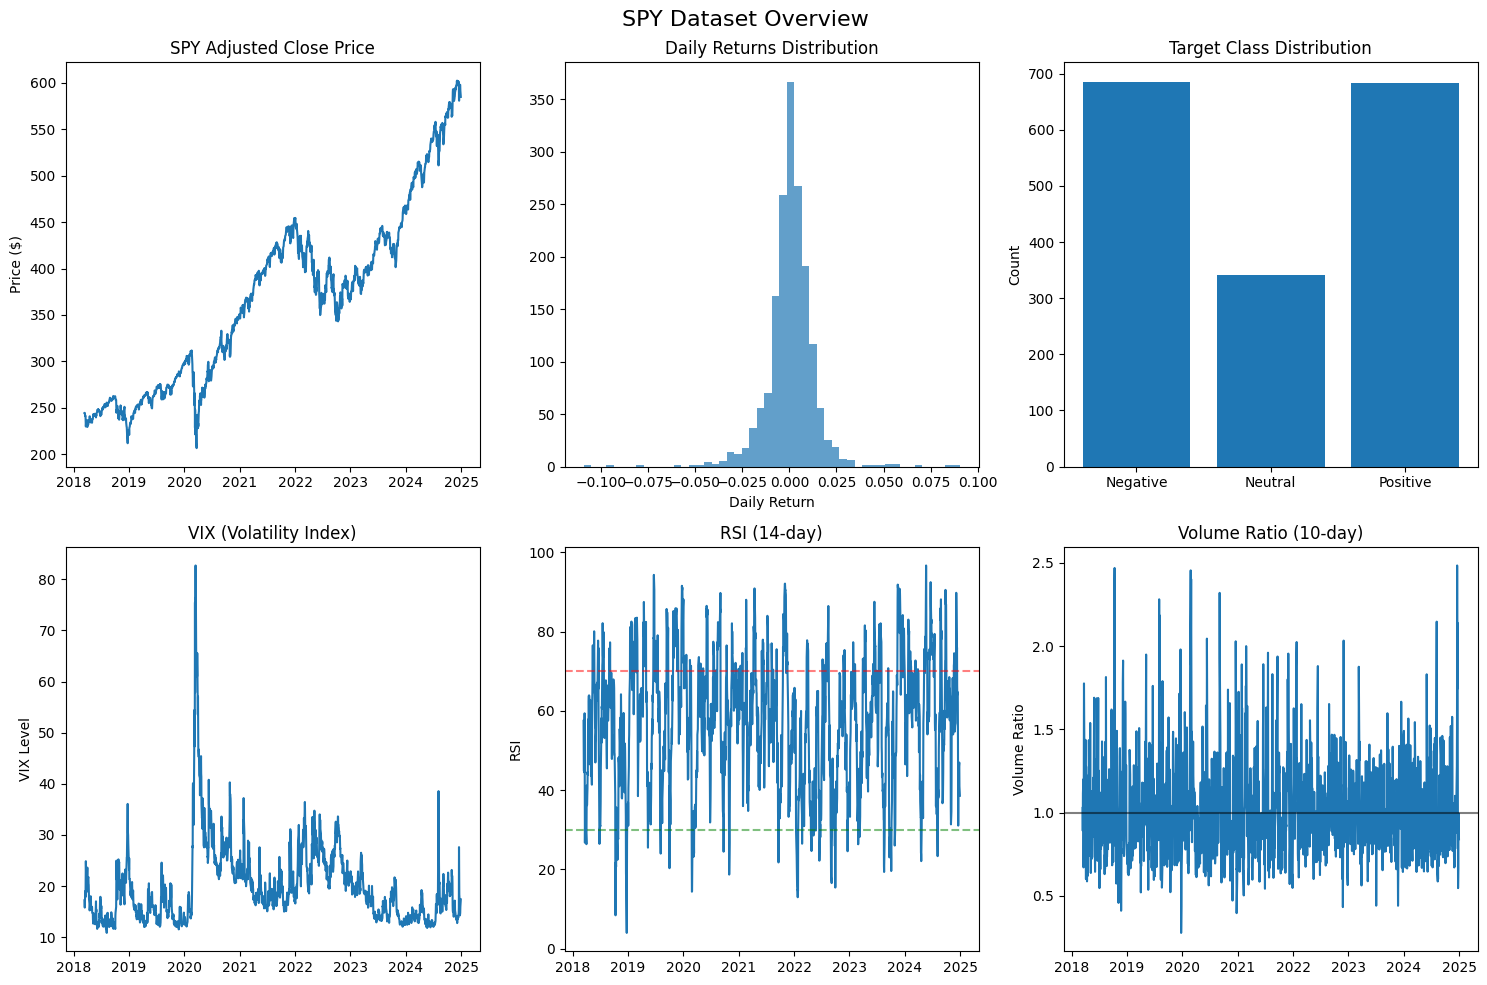

In [51]:
key_features = ['spy_return_1d', 'spy_rsi_14', 'spy_volatility_10d', 'spy_volume_ratio_10d', 'vix_close']
print("📈 Key Feature Statistics:")
print(features_clean[key_features].describe())

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('SPY Dataset Overview', fontsize=16)

# Plot 1: SPY Price over time
axes[0,0].plot(features_clean.index, features_clean['spy_close'])
axes[0,0].set_title('SPY Adjusted Close Price')
axes[0,0].set_ylabel('Price ($)')

# Plot 2: Daily returns distribution
axes[0,1].hist(features_clean['spy_return_1d'].dropna(), bins=50, alpha=0.7)
axes[0,1].set_title('Daily Returns Distribution')
axes[0,1].set_xlabel('Daily Return')

# Plot 3: Target class distribution
target_counts = features_clean['target'].value_counts().sort_index()
axes[0,2].bar(['Negative', 'Neutral', 'Positive'], target_counts.values)
axes[0,2].set_title('Target Class Distribution')
axes[0,2].set_ylabel('Count')

# Plot 4: VIX over time
axes[1,0].plot(features_clean.index, features_clean['vix_close'])
axes[1,0].set_title('VIX (Volatility Index)')
axes[1,0].set_ylabel('VIX Level')

# Plot 5: RSI over time
axes[1,1].plot(features_clean.index, features_clean['spy_rsi_14'])
axes[1,1].axhline(y=70, color='r', linestyle='--', alpha=0.5)
axes[1,1].axhline(y=30, color='g', linestyle='--', alpha=0.5)
axes[1,1].set_title('RSI (14-day)')
axes[1,1].set_ylabel('RSI')

# Plot 6: Volume ratio over time
axes[1,2].plot(features_clean.index, features_clean['spy_volume_ratio_10d'])
axes[1,2].axhline(y=1, color='black', linestyle='-', alpha=0.5)
axes[1,2].set_title('Volume Ratio (10-day)')
axes[1,2].set_ylabel('Volume Ratio')

plt.tight_layout()
plt.show()

In [52]:
print("\n🔗 Feature Correlation with Target:")
feature_correlations = features_clean[feature_columns + ['target']].corr()['target'].abs().sort_values(ascending=False)
print(feature_correlations.head(10))


🔗 Feature Correlation with Target:
target                  1.000000
spy_rsi_14              0.049703
spy_gap                 0.043396
spy_overnight_return    0.043396
spy_bb_position         0.042709
vix_sma_50              0.040878
vix_sma_20              0.034759
vix_sma_10              0.033417
vix_sma_5               0.032733
spy_return_5d           0.031243
Name: target, dtype: float64
